# ViT for FashionMNIST Classification

# Setup

As usual, we start with basic data loading and preprocessing.

In [4]:
!pip install einops

In [5]:
import torch
from torch import nn
from torch import nn, einsum
import torch.nn.functional as F
from torch import optim

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np
import torchvision
import time

In [6]:
torch.manual_seed(42)

DOWNLOAD_PATH = '/data/fashionmnist'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

transform_fashionmnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.5,), (0.5,))])

train_set = torchvision.datasets.FashionMNIST(DOWNLOAD_PATH, train=True, download=True,
                                              transform=transform_fashionmnist)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_set = torchvision.datasets.FashionMNIST(DOWNLOAD_PATH, train=False, download=True,
                                             transform=transform_fashionmnist)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

# The ViT Model



We will now set up the ViT model. There will be 3 parts to this model:

* A ``patch embedding'' layer that takes an image and tokenizes it. There is some amount of tensor algebra involved here (since we have to slice and dice the input appropriately), and the `einops` package is helpful. We will also add learnable positional encodings as parameters.
* A sequence of transformer blocks. This will be a smaller scale replica of the original proposed ViT, except that we will only use 4 blocks in our model (instead of 32 in the actual ViT).
* A (dense) classification layer at the end.

Further, each transformer block consists of the following components:

* A *self-attention* layer with $H$ heads,
* A one-hidden-layer (dense) network to collapse the various heads. For the hidden neurons, the original ViT used something called a [GeLU](https://arxiv.org/pdf/1606.08415.pdf) activation function, which is a smooth approximation to the ReLU. For our example, regular ReLUs seem to be working just fine. The original ViT also used Dropout but we won't need it here.
* *layer normalization* preceeding each of the above operations.

Some care needs to be taken in making sure the various dimensions of the tensors are matched.

In [7]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0.1, emb_dropout = 0.1):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [8]:
model = ViT(image_size=28, patch_size=4, num_classes=10, channels=1, dim=64, depth=6, heads=4, mlp_dim=128)
optimizer = optim.Adam(model.parameters(), lr=0.003)

Let's see how the model looks like.

In [9]:
model

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): Linear(in_features=16, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=64, out_features=768, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=256, out_features=64, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=64, out_features=128, bias=True)
              (1): GELU(approximate='none')
   

This is it -- 4 transformer blocks, followed by a linear classification layer. Let us quickly see how many trainable parameters are present in this model.

In [10]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

499722


About half a million. Not too bad; the bigger NLP type models have several tens of millions of parameters. But since we are training on MNIST this should be more than sufficient.

# Training and testing

All done! We can now train the ViT model. The following again is boilerplate code.


In [11]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())


In [12]:
def evaluate(model, data_loader, loss_history):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [13]:
N_EPOCHS = 5

start_time = time.time()


train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, test_loader, test_loss_history)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/60000 (  0%)]  Loss: 2.3301
[10000/60000 ( 17%)]  Loss: 0.7253
[20000/60000 ( 33%)]  Loss: 0.8560
[30000/60000 ( 50%)]  Loss: 0.6764
[40000/60000 ( 67%)]  Loss: 0.4667
[50000/60000 ( 83%)]  Loss: 0.5642

Average test loss: 0.5360  Accuracy: 8046/10000 (80.46%)

Epoch: 2
[    0/60000 (  0%)]  Loss: 0.5059
[10000/60000 ( 17%)]  Loss: 0.5830
[20000/60000 ( 33%)]  Loss: 0.6174
[30000/60000 ( 50%)]  Loss: 0.5978
[40000/60000 ( 67%)]  Loss: 0.5770
[50000/60000 ( 83%)]  Loss: 0.5170

Average test loss: 0.4894  Accuracy: 8210/10000 (82.10%)

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.3677
[10000/60000 ( 17%)]  Loss: 0.5505
[20000/60000 ( 33%)]  Loss: 0.3479
[30000/60000 ( 50%)]  Loss: 0.5518
[40000/60000 ( 67%)]  Loss: 0.3990
[50000/60000 ( 83%)]  Loss: 0.3444

Average test loss: 0.4993  Accuracy: 8138/10000 (81.38%)

Epoch: 4
[    0/60000 (  0%)]  Loss: 0.4412
[10000/60000 ( 17%)]  Loss: 0.5441
[20000/60000 ( 33%)]  Loss: 0.5137
[30000/60000 ( 50%)]  Loss: 0.4804
[40000/60000 ( 67

In [14]:
evaluate(model, test_loader, test_loss_history)


Average test loss: 0.4437  Accuracy: 8375/10000 (83.75%)



We get an accuracy of 83.75% for test samples, which is satisfactory for now. We can further finetune it for practical uses.

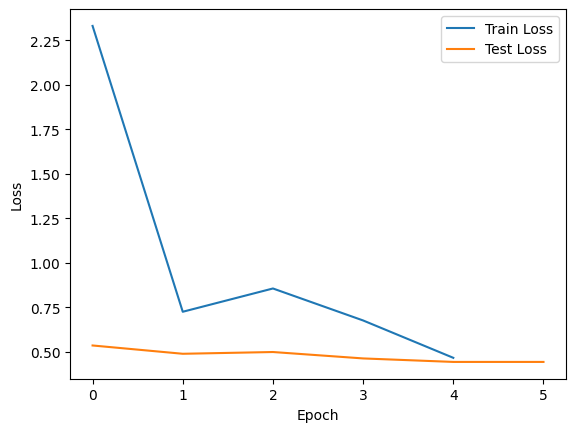

In [18]:
import matplotlib.pyplot as plt

def plot_history(train_loss_history, test_loss_history):
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(test_loss_history, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(train_loss_history[0:5], test_loss_history)